# DataFrame Operations

## About the Data
In this notebook, we will be working with 2 datasets:
- Facebook's stock price throughout 2018 (obtained using the [`stock_analysis` package](https://github.com/stefmolin/stock-analysis)).
- Daily weather data for NYC from the [National Centers for Environmental Information (NCEI) API](https://www.ncdc.noaa.gov/cdo-web/webservices/v2).

*Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for "NCEI weather API" to find the updated one.*

## Background on the weather data

Data meanings:
- `AWND`: average wind speed
- `PRCP`: precipitation in millimeters
- `SNOW`: snowfall in millimeters
- `SNWD`: snow depth in millimeters
- `TMAX`: maximum daily temperature in Celsius
- `TMIN`: minimum daily temperature in Celsius

## Setup

In [3]:
import numpy as np
import pandas as pd

weather = pd.read_csv('/content/drive/MyDrive/Hands-On-Data-Analysis-with-Pandas-2nd-edition/ch_04/data/nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,",0.0
2,2018-01-01,SNOW,GHCND:US1NJBG0015,",,N,",0.0
3,2018-01-01,PRCP,GHCND:US1NJBG0017,",,N,",0.0
4,2018-01-01,SNOW,GHCND:US1NJBG0017,",,N,",0.0


In [9]:
fb = pd.read_csv('/content/drive/MyDrive/Hands-On-Data-Analysis-with-Pandas-2nd-edition/ch_04/data/fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


## Arithmetic and statistics
We already saw that we can use mathematical operators like `+` and `/` with dataframes directly. However, we can also use methods, which allow us to specify the axis to perform the calculation over. By default, this is per column. Let's find the Z-scores for the volume traded and look at the days where this was more than 3 standard deviations from the mean:

In [10]:
fb.assign(
    abs_z_score_volume=lambda x: \
        x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3')

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


We can use `rank()` and `pct_change()` to see which days had the largest change in volume traded from the day before:

In [11]:
fb.assign(
    volume_pct_change=fb.volume.pct_change(),
    pct_change_rank=lambda x: \
        x.volume_pct_change.abs().rank(ascending=False)
).nsmallest(5, 'pct_change_rank')

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


January 12th was when the news that Facebook changed its news feed product to focus more on content from a users' friends over the brands they follow. Given that Facebook's advertising is a key component of its business ([nearly 89% in 2017](https://www.investopedia.com/ask/answers/120114/how-does-facebook-fb-make-money.asp)), many shares were sold and the price dropped in panic:

In [12]:
fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


Throughout 2018, Facebook's stock price never had a low above $215:

In [13]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

Facebook's OHLC (open, high, low, and close) prices all had at least one day they were at $215 or less:

In [14]:
(fb > 215).all()

open      False
high      False
low       False
close     False
volume     True
dtype: bool

## Binning
When working with volume traded, we may be interested in ranges of volume rather than the exact values. No two days have the same volume traded:

In [15]:
(fb.volume.value_counts() > 1).sum()

0

We can use `pd.cut()` to create 3 bins of even range in volume traded and name them. Then we can work with low, medium, and high volume traded categories:

In [16]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

low     240
med       8
high      3
Name: volume, dtype: int64

Let's look at the days with high trading volume:

In [17]:
fb[volume_binned == 'high'].sort_values('volume', ascending=False)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


July 25th Facebook announced disappointing user growth and the stock tanked in the after hours:

In [18]:
fb['2018-07-25':'2018-07-26']

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


Cambridge Analytica scandal broke on Saturday, March 17th, so we look at the Monday after for the numbers:

In [19]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


Since most days have similar volume, but a few are very large, we have very wide bins. Most of the data is in the low bin.

*Note: visualizations will be covered in chapters 5 and 6.*

In [20]:
from visual_aids.misc_viz import low_med_high_bins_viz

low_med_high_bins_viz(
    fb, 'volume', ylabel='volume traded',
    title='Daily Volume Traded of Facebook Stock in 2018 (with bins)'
)

ModuleNotFoundError: ignored

If we split using quantiles, the bins will have roughly the same number of observations. For this, we use `qcut()`. We will make 4 quartiles:

In [21]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

q1    63
q2    63
q4    63
q3    62
Name: volume, dtype: int64

Notice the bins don't cover ranges of the same size anymore:

In [22]:
from visual_aids.misc_viz import quartile_bins_viz

quartile_bins_viz(
    fb, 'volume', ylabel='volume traded',
    title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)'
)

ModuleNotFoundError: ignored

## Applying Functions
We can use the `apply()` method to run the same operation on all columns (or rows) of the dataframe. First, let's isolate the weather observations from the Central Park station and pivot the data:

In [23]:
central_park_weather = weather\
    .query('station == "GHCND:USW00094728"')\
    .pivot(index='date', columns='datatype', values='value')

Let's calculate the Z-scores of the TMIN, TMAX, and PRCP observations in Central Park in October 2018:

In [24]:
oct_weather_z_scores = central_park_weather\
    .loc['2018-10', ['TMIN', 'TMAX', 'PRCP']]\
    .apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,31.0,-1.790682e-16,1.0,-1.339112,-0.751019,-0.474269,1.065152,1.843511
TMAX,31.0,1.951844e-16,1.0,-1.305582,-0.870013,-0.138258,1.011643,1.604016
PRCP,31.0,4.655774e-17,1.0,-0.394438,-0.394438,-0.394438,-0.240253,3.936167


October 27th rained much more than the rest of the days:

In [25]:
oct_weather_z_scores.query('PRCP > 3').PRCP

date
2018-10-27    3.936167
Name: PRCP, dtype: float64

Indeed, this day was much higher than the rest:

In [26]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64

When the function we want to apply isn't vectorized, we can:
- use `np.vectorize()` to vectorize it (similar to how `map()` works) and then use it with `apply()`
- use `applymap()` and pass it the non-vectorized function directly

Say we wanted to count the digits of the whole numbers for the Facebook data; `len()` is not vectorized, so we can use `np.vectorize()` or `applymap()`:

In [27]:
fb.apply(
    lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(
    fb.applymap(lambda x: len(str(np.ceil(x))))
)

True

A simple operation of addition to each element in a series grows linearly in time complexity when using `iteritems()`, but stays near 0 when using vectorized operations. `iteritems()` and related methods should only be used if there is no vectorized solution:

<ipython-input-28-c27e27620a04>:24: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, v in test.iteritems():


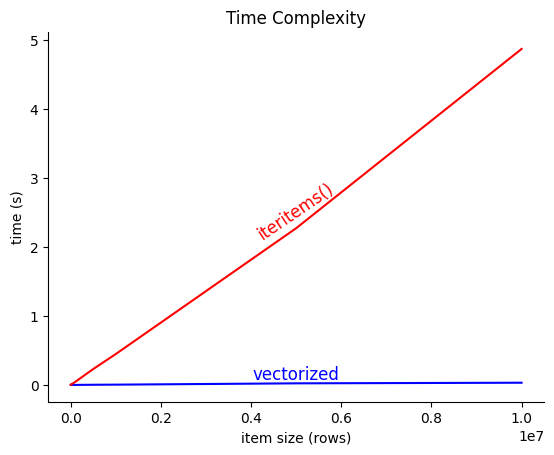

In [28]:
import time

import numpy as np
import pandas as pd

np.random.seed(0)

vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
    # set of numbers to use
    test = pd.Series(np.random.uniform(size=size))

    # time the vectorized operation
    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start

    # time the operation with `iteritems()`
    start = time.time()
    x = []
    for i, v in test.iteritems():
        x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    iteritems_results[size] = end - start

results = pd.DataFrame(
    [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T

# plotting
ax = results.plot(title='Time Complexity', color=['blue', 'red'], legend=False)

# formatting
ax.set(xlabel='item size (rows)', ylabel='time (s)')
ax.text(0.5e7, iteritems_results[0.5e7] * .9, 'iteritems()', rotation=34, color='red', fontsize=12, ha='center', va='bottom')
ax.text(0.5e7, vectorized_results[0.5e7], 'vectorized', color='blue', fontsize=12, ha='center', va='bottom')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

## Window Calculations
*Consult the [`understanding_window_calculations.ipynb`](./understanding_window_calculations.ipynb) notebook for interactive visualizations using widgets to help understand window calculations.*

The `rolling()` method allows us to perform rolling window calculations. We simply specify the window size (3 days here) and follow it with a call to an aggregation function (sum here):

In [29]:
central_park_weather.loc['2018-10'].assign(
    rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

date,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07
datatype,,,,,,,
PRCP,0.0,17.5,0.0,1.0,0.0,0.0,0.0
rolling_PRCP,0.0,17.5,17.5,18.5,1.0,1.0,0.0


We can also perform the rolling calculations on the entire dataframe at once. This will apply the same aggregation function to each column:

In [30]:
central_park_weather.loc['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,
2018-10-01,0.900000,0.000000,0.0,0.0,24.400000,17.200000
2018-10-02,0.900000,8.750000,0.0,0.0,24.700000,17.750000
2018-10-03,0.966667,5.833333,0.0,0.0,24.233333,17.566667
2018-10-04,0.800000,6.166667,0.0,0.0,24.233333,17.200000
2018-10-05,1.033333,0.333333,0.0,0.0,23.133333,16.300000
2018-10-06,0.833333,0.333333,0.0,0.0,22.033333,16.300000
2018-10-07,1.066667,0.000000,0.0,0.0,22.600000,17.400000


We can use different aggregation functions per column if we use `agg()` instead. We pass in a dictionary mapping the column to the aggregation to perform on it. Here, we join the result to the original data to see what is happening:

In [31]:
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
    lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


Suppose we reindexed the Facebook stock data as we did with the S&P 500 data in chapter 3. If we were to use rolling calculations on this data, we would be including the values when the market was closed:

In [32]:
fb_reindexed = fb\
    .reindex(pd.date_range('2018-01-01', '2018-12-31', freq='D'))\
    .assign(
        volume=lambda x: x.volume.fillna(0),
        close=lambda x: x.close.fillna(method='ffill'),
        open=lambda x: x.open.combine_first(x.close),
        high=lambda x: x.high.combine_first(x.close),
        low=lambda x: x.low.combine_first(x.close)
    )
fb_reindexed.assign(day=lambda x: x.index.day_name()).head(10)

,open,high,low,close,volume,day
2018-01-01,NaN,NaN,NaN,NaN,0.0,Monday
2018-01-02,177.68,181.58,177.5500,181.42,18151903.0,Tuesday
2018-01-03,181.88,184.78,181.3300,184.67,16886563.0,Wednesday
2018-01-04,184.90,186.21,184.0996,184.33,13880896.0,Thursday
2018-01-05,185.59,186.90,184.9300,186.85,13574535.0,Friday
2018-01-06,186.85,186.85,186.8500,186.85,0.0,Saturday
2018-01-07,186.85,186.85,186.8500,186.85,0.0,Sunday
2018-01-08,187.20,188.90,186.3300,188.28,17994726.0,Monday
2018-01-09,188.70,188.80,187.1000,187.87,12393057.0,Tuesday
2018-01-10,186.94,187.89,185.6300,187.84,10529894.0,Wednesday


As of version 1.0, `pandas` supports defining custom windows for rolling calculations, which makes it possible for us to perform rolling calculations on the days the market was open. One way is to make a new class that inherits from `BaseIndexer` and provide the logic for determining the window bounds in the `get_window_bounds()` method (more info [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#custom-window-rolling)). For our use case, we can use the `VariableOffsetWindowIndexer` class, which was introduced in version 1.1, to perform rolling calculations over non-fixed time offsets (like business days). Let's perform a three business day rolling calculation on the reindexed Facebook stock data and join it with the reindexed data for comparison:

In [33]:
from pandas.api.indexers import VariableOffsetWindowIndexer

indexer = VariableOffsetWindowIndexer(
    index=fb_reindexed.index, offset=pd.offsets.BDay(3)
)
fb_reindexed.assign(window_start_day=0).rolling(indexer).agg({
    'window_start_day': lambda x: x.index.min().timestamp(),
    'open': 'mean', 'high': 'max', 'low': 'min',
    'close': 'mean', 'volume': 'sum'
}).join(
    fb_reindexed, lsuffix='_rolling'
).sort_index(axis=1).assign(
    day=lambda x: x.index.day_name(),
    window_start_day=lambda x: pd.to_datetime(x.window_start_day, unit='s')
).head(10)

,close,close_rolling,high,high_rolling,low,low_rolling,open,open_rolling,volume,volume_rolling,window_start_day,day
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2018-01-01,Monday
2018-01-02,181.42,181.420000,181.58,181.58,177.5500,177.5500,177.68,177.680000,18151903.0,18151903.0,2018-01-01,Tuesday
2018-01-03,184.67,183.045000,184.78,184.78,181.3300,177.5500,181.88,179.780000,16886563.0,35038466.0,2018-01-01,Wednesday
2018-01-04,184.33,183.473333,186.21,186.21,184.0996,177.5500,184.90,181.486667,13880896.0,48919362.0,2018-01-02,Thursday
2018-01-05,186.85,185.283333,186.90,186.90,184.9300,181.3300,185.59,184.123333,13574535.0,44341994.0,2018-01-03,Friday
2018-01-06,186.85,186.010000,186.85,186.90,186.8500,184.0996,186.85,185.780000,0.0,27455431.0,2018-01-04,Saturday
2018-01-07,186.85,186.220000,186.85,186.90,186.8500,184.0996,186.85,186.047500,0.0,27455431.0,2018-01-04,Sunday
2018-01-08,188.28,186.632000,188.90,188.90,186.3300,184.0996,187.20,186.278000,17994726.0,45450157.0,2018-01-04,Monday
2018-01-09,187.87,187.340000,188.80,188.90,187.1000,184.9300,188.70,187.038000,12393057.0,43962318.0,2018-01-05,Tuesday
2018-01-10,187.84,187.538000,187.89,188.90,185.6300,185.6300,186.94,187.308000,10529894.0,40917677.0,2018-01-06,Wednesday


Rolling calculations (`rolling()`) use a sliding window. Expanding calculations (`expanding()`), however, grow in size. These are equivalent to cumulative aggregations like `cumsum()`; however, we can specify the minimum number of periods required to start calculating (default is 1), and we aren't limited to predefined aggregations. Therefore, while there is no method for the cumulative mean, we can calculate it using `expanding()`. Let's calculate the month-to-date average precipiation:

In [34]:
central_park_weather.loc['2018-06'].assign(
    TOTAL_PRCP=lambda x: x.PRCP.cumsum(),
    AVG_PRCP=lambda x: x.PRCP.expanding().mean()
).head(10)[['PRCP', 'TOTAL_PRCP', 'AVG_PRCP']].T

date,2018-06-01,2018-06-02,2018-06-03,2018-06-04,2018-06-05,2018-06-06,2018-06-07,2018-06-08,2018-06-09,2018-06-10
datatype,,,,,,,,,,
PRCP,6.9,2.00,6.4,4.10,0.00,0.000000,0.000000,0.000,0.000000,0.30
TOTAL_PRCP,6.9,8.90,15.3,19.40,19.40,19.400000,19.400000,19.400,19.400000,19.70
AVG_PRCP,6.9,4.45,5.1,4.85,3.88,3.233333,2.771429,2.425,2.155556,1.97


We can also use `agg()` to specify aggregations per column. Note that this works with NumPy functions as well. Here, we join the expanding calculations with the original results for comparison:

In [35]:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
    {'TMAX': np.max, 'TMIN': np.min, 'AWND': np.mean, 'PRCP': np.sum}
).join(
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
    lsuffix='_expanding'
).sort_index(axis=1)

datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.928571,0.0,18.5,26.1,26.1,19.4,15.6


Pandas provides the `ewm()` method for exponentially weighted moving calculations. As we saw in chapter 1, we can use the exponentially weighted moving average to smooth the data. Let's compare the rolling mean to the exponentially weighted moving average with the maximum daily temperature. Note that `span` here is the periods to use:

In [36]:
central_park_weather.assign(
    AVG=lambda x: x.TMAX.rolling('30D').mean(),
    EWMA=lambda x: x.TMAX.ewm(span=30).mean()
).loc['2018-09-29':'2018-10-08', ['TMAX', 'EWMA', 'AVG']].T

date,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08
datatype,,,,,,,,,,
TMAX,22.200000,21.100000,24.400000,25.000000,23.300000,24.400000,21.700000,20.000000,26.100000,23.300000
EWMA,24.410887,24.197281,24.210360,24.261304,24.199285,24.212234,24.050154,23.788854,23.937960,23.896802
AVG,24.723333,24.573333,24.533333,24.460000,24.163333,23.866667,23.533333,23.070000,23.143333,23.196667


*Consult the [`understanding_window_calculations.ipynb`](./understanding_window_calculations.ipynb) notebook for interactive visualizations to help understand window calculations.*

## Pipes
Pipes are a way to streamline our `pandas` code and make it more readable and flexible. Using pipes, we can take a nested call like

```python
f(g(h(data), 20), x=True)
```

and turn it into something more readable:

```python
data.pipe(h)\
    .pipe(g, 20)\
    .pipe(f, x=True)\
```

We can use pipes to apply any function that accepts our data as the first argument and pass in any additional arguments. This makes it easy to chain steps together regardless of whether they are methods or functions:

We can pass any function that will accept the caller of `pipe()` as the first argument:

In [37]:
def get_info(df):
    return '%d rows, %d columns and max closing Z-score was %d' % (*df.shape, df.close.max())

get_info(fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))\
    == fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)

True

For example, passing `pd.DataFrame.rolling` to `pipe()` is equivalent to calling `rolling()` directly on the dataframe, except we have more flexiblity to change this:

In [38]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

True

The pipe takes the function passed in and calls it with the object that called `pipe()` as the first argument. Positional and keyword arguments are passed down:

In [42]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

We can use a pipe to make a function that we can use for all of our window calculation needs:

In [ ]:
from window_calc import window_calc
window_calc??

We can use the same interface to calculate various window calculations now. Let's find the expanding median for the Facebook data:

In [ ]:
window_calc(fb, pd.DataFrame.expanding, np.median).head()

Using the exponentially weighted moving average requires we pass in a keyword argument:

In [ ]:
window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.680000,181.580000,177.550000,181.420000,1.815190e+07
2018-01-03,180.480000,183.713333,180.070000,183.586667,1.730834e+07
2018-01-04,183.005714,185.140000,182.372629,184.011429,1.534980e+07
2018-01-05,184.384000,186.078667,183.736560,185.525333,1.440299e+07
2018-01-08,185.837419,187.534839,185.075110,186.947097,1.625679e+07


With rolling calculations, we can pass in a positional argument for the window size:

In [ ]:
window_calc(
    central_park_weather.loc['2018-10'],
    pd.DataFrame.rolling,
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'},
    '3D'
).head()

,TMAX,TMIN,AWND,PRCP
date,,,,
2018-10-01,24.4,17.2,0.900000,0.0
2018-10-02,25.0,17.2,0.900000,17.5
2018-10-03,25.0,17.2,0.966667,17.5
2018-10-04,25.0,16.1,0.800000,18.5
2018-10-05,24.4,15.6,1.033333,1.0


<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
         <a href="./1-querying_and_merging.ipynb">
            <button>&#8592; Previous Notebook</button>
        </a>
        <a href="./understanding_window_calculations.ipynb">
            <button>Understanding Window Calculations</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="./3-aggregations.ipynb">
            <button>Next Notebook &#8594;</button>
        </a>
    </div>
</div>
<hr>